<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2020/blob/master/micom_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧫🦠 Modeling microbiota-wide metabolism with MICOM

This notebook will accompany the second session of the 2020 ISB Microbiome Course. The presentation slides can be [found here](https://gibbons-lab.github.io/isb_course_2020/micom). 

You can save your own local copy of this notebook by using `File > Save a copy in Drive`. You may be promted to cetify the notebook is safe. We promise that it is 🤞

**Disclaimer:**
The linear and quadratic programming problems MICOM has to solve are very large and very complicated. There are some very good commercial solvers that are very expensive (even though they are often free for academic use). To make this tutorial as accessible as possible we will use the Open Source solver [OSQP](https://osqp.org/). OSQP is amazing with quadratic programming problems (kudos!) but not as accurate for linear problems. Solvers usually only guarantee a solution within a certain numerical tolerance of the real solution. In order to make everything work with OSQP this tolerance has to be relaxed to about 10<sup>-3</sup>. This means that any result with an absolute value smaller than that might very well be zero so we should look at larger values only. Installing cost-free academic versions of commercial solvers like [IBM CPLEX](https://www.ibm.com/analytics/cplex-optimizer) or [Gurobi](https://www.gurobi.com/) would alow you to lower the tolerance to 10<sup>-6</sup>.



# 📝 Setup

MICOM installation is is usually pretty straight-forward and can be as easy as typing `pip install micom` into your Terminal. However, MICOM will require a solver for quadratic programming problems and all the best ones are commercial (boo) even though they often have free academic licenses 😌. We will use a brand new open source QP solver named OSQP, but this will require us to pull in development versions of certain packages.

But first let's start by downloading the materials again and switching to the folder.

In [1]:
!git clone https://github.com/gibbons-lab/isb_course_2020 materials
%cd materials

Cloning into 'materials'...
remote: Enumerating objects: 1322, done.
remote: Total 1322 (delta 0), reused 0 (delta 0), pack-reused 1322
Receiving objects: 100% (1322/1322), 190.63 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (525/525), done.
Checking out files: 100% (1109/1109), done.
/content/materials


## Basic Installation

Installing MICOM is straight-forward in Python. OSQP itself can be installed right along with it.

In [2]:
!pip install -q micom

print("Done! 🎉 ")

     |████████████████████████████████| 828 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 36.9 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 6.8 MB 21.1 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 44 kB 2.9 MB/s 
     |████████████████████████████████| 11.1 MB 33.3 MB/s 
     |████████████████████████████████| 109 kB 60.2 MB/s 
     |████████████████████████████████| 232 kB 41.5 MB/s 
     |████████████████████████████████| 147 kB 47.6 MB/s 
     |████████████████████████████████| 2.3 MB 39.0 MB/s 
     |████████████████████████████████| 68 kB 5.5 MB/s 
     |████████████████████████████████| 80 kB 6.9 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 51 kB 5.3 MB/s 
     |████████████████████████████████| 546 kB 45.3 MB/s 
Done! 🎉 


## Enable QIIME 2 interactions

Finally we will need to install packages to read the "biom" format which is a file format QIIME 2 uses to save tables. This is only necessary if you want to read QIIME 2 FeatureTable artifacts.

In [3]:
!pip install -q numpy Cython
!pip install -q biom-format

print("Done! 🎉 ")

     |████████████████████████████████| 11.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Done! 🎉 


Okay, all done. So let's get started 😁.

# 💻 MICOM

We will use the Python interface to MICOM since it plays nicely with Colaboratory. However, you could run the same steps within the QIIME 2 MICOM plugin ([q2-micom](https://library.qiime2.org/plugins/q2-micom/26/)). 

Here is an overview of all the steps and functions:
![micom overview](https://github.com/micom-dev/q2-micom/raw/706f583a060b91c12c0cec7acea2354fdd0dd320/docs/assets/overview.png).

MICOM starts from a combined abundance/taxonomy table, which MICOM abbreviates to a taxonomy table. To see how those tables look we can import MICOM and look at an example table:


In [4]:
from micom.data import test_data

test_data().head()

,id,genus,species,reactions,metabolites,sample_id,abundance
0,Escherichia_coli_1,Escherichia,Escherichia coli 0,95,72,sample_1,232
1,Escherichia_coli_2,Escherichia,Escherichia coli 1,95,72,sample_1,572
2,Escherichia_coli_3,Escherichia,Escherichia coli 2,95,72,sample_1,790
3,Escherichia_coli_4,Escherichia,Escherichia coli 3,95,72,sample_1,957
0,Escherichia_coli_1,Escherichia,Escherichia coli 0,95,72,sample_2,578


The `file` column is not required when using a taxonomy database like we will do here. The `id` column specifies identifiers for the taxa and should be expressive and not include spaces or special characters. Each row needs to contain the the abundance of a single taxon in a single sample. 

Oh no, that's not what we have generated in the previous step. We only have separate QIIME 2 artifacts 😱 

No worries, we can deal with that.

## Importing data from QIIME 2

MICOM can read QIIME 2 artifacts. You don't even need to have QIIME 2 installed for that! But before we do so, let's resolve one issue. We discussed that MICOM summarizes genome-scale models into pangenome-scale models as a first step, but our data are on the ASV level...so how will we know what to summarize? Basically, specific model database can be used to quickly summarize pangenome-scale models for use within MICOM. So, before we read our data we have to decide which model database to use. We will go with the [AGORA database](https://pubmed.ncbi.nlm.nih.gov/27893703/), which is a curated database of more than 800 bacterial strains that commonly live in the human gut. In particular, we will use a version of this database summarized on the genus rank.



In [5]:
!wget -O agora103_genus.qza https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1

--2022-06-13 19:25:48--  https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21080080 (20M) [application/octet-stream]
Saving to: ‘agora103_genus.qza’

agora103_genus.qza  100%[===================>]  20.10M  2.07MB/s    in 12s     

2022-06-13 19:26:02 (1.68 MB/s) - ‘agora103_genus.qza’ saved [21080080/21080080]



Okay. We've got everything we need now. The data from the prior analysis can be found in the `treasure_chest` folder, so we can use those files.

In [6]:
from micom.taxonomy import qiime_to_micom

tax = qiime_to_micom(
    "treasure_chest/dada2/table.qza", 
    "treasure_chest/taxa.qza", 
    collapse_on="genus"
)

Notice the `collapse_on` argument. That will specify the rank on which to sumarize and can be a list of several ranks. When matching taxonomy you can either match by the particular rank of interest (for example, just comparing genus names here), or you could compare the entire taxonomy, which will require all taxonomic ranks prior to the target rank to match. For that you cloud specify `collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]`. 

Taxonomic names will often not match 100% between databases. For instance, the genus name "Prevotella" in one database may be "Prevotella_6" in another. The more ranks you use for matching the more likely are you to run into those issues. However, the more taxonomic ranks you use to match the more confident you can be that your observed taxon really is the same taxon as the one in the model database.

The resulting table will contain the same abundances but it will include more ranks if `collapse_on` is a list. All ranks present in the taxonomy will be used when matching to the database. The GreenGenes database is pretty old and many taxonomic names have been superceded by now. So we will stick with the "lax" option of only matching on genus ranks.

We can also look at the generated MICOM taxonomy.

In [7]:
tax

,sample_id,abundance,genus,id,relative
8,ERR1883210,11.0,Akkermansia,Akkermansia,0.000164
9,ERR1883214,54717.0,Akkermansia,Akkermansia,0.822404
10,ERR1883247,102.0,Akkermansia,Akkermansia,0.003015
11,ERR1883248,4059.0,Akkermansia,Akkermansia,0.103046
12,ERR1883210,42793.0,Bacteroides,Bacteroides,0.637674
...,...,...,...,...,...
257,ERR1883294,3.0,Atopobium,Atopobium,0.000647
258,ERR1883294,3.0,Alicyclobacillus,Alicyclobacillus,0.000647
259,ERR1883212,4.0,WAL_1855D,WAL_1855D,0.000069
260,ERR1883212,2.0,Finegoldia,Finegoldia,0.000035


One helpful thing to do is to merge in our metadata, so we'll have it at hand for the following steps.

In [8]:
import pandas as pd

metadata = pd.read_table("metadata.tsv").rename(columns={"id": "sample_id"})
tax = pd.merge(tax, metadata, on="sample_id")
tax

,sample_id,abundance,genus,id,relative,disease_stat,description
0,ERR1883210,11.0,Akkermansia,Akkermansia,0.000164,healthy,Donor 13
1,ERR1883210,42793.0,Bacteroides,Bacteroides,0.637674,healthy,Donor 13
2,ERR1883210,3298.0,Faecalibacterium,Faecalibacterium,0.049145,healthy,Donor 13
3,ERR1883210,1062.0,Clostridium,Clostridium,0.015825,healthy,Donor 13
4,ERR1883210,4556.0,Roseburia,Roseburia,0.067891,healthy,Donor 13
...,...,...,...,...,...,...,...
249,ERR1883315,48.0,Selenomonas,Selenomonas,0.004828,Recurrent Clostridium difficile infection,Day -1 CD4
250,ERR1883315,28.0,Microvirgula,Microvirgula,0.002816,Recurrent Clostridium difficile infection,Day -1 CD4
251,ERR1883315,3.0,Aggregatibacter,Aggregatibacter,0.000302,Recurrent Clostridium difficile infection,Day -1 CD4
252,ERR1883315,11.0,Providencia,Providencia,0.001106,Recurrent Clostridium difficile infection,Day -1 CD4


With the taxonomic metadata, we can finally build our community-level models.

## Building community models

With the data we have now, building our models is pretty easy. We just pass our taxonomy table and model database to MICOM. We will have to specify where to write the models. We will also run that in parallel over two threads. We will remove all taxa that make up less than 2.5% of the community to keep the models small and speed up this tutorial. It should take around 10 minutes to finish.

In [9]:
from micom.workflows import build
from micom import Community
import pandas as pd

manifest = build(tax, "agora103_genus.qza", "models", solver="osqp", 
                 cutoff=2.5e-2, threads=2)


Output()

For different data a warning may pop up if less than 50% of the abundances can be matched to the database. If this happens, you can still continue, but be aware that such a sparse model may not accurately represent your sample. In lower-biomass 16S amplicon sequencing samples from stool, many reads can match to food components or to host mitochondria and these hits probably do not contribute much to bacterial community metabolism. These hits will be excluded from MICOM. 

We won't see any warnings here. So, we will go ahead for now. Let's also take a look what we got back from the `build` process.

In [10]:
manifest

,sample_id,disease_stat,description,file,found_taxa,total_taxa,found_fraction,found_abundance_fraction
0,ERR1883210,healthy,Donor 13,ERR1883210.pickle,5.0,5.0,1.000000,0.822257
1,ERR1883212,healthy,Donor 14,ERR1883212.pickle,9.0,10.0,0.900000,0.847637
2,ERR1883214,Recurrent Clostridium difficile infection,Day 0 CD1,ERR1883214.pickle,3.0,3.0,1.000000,0.965912
3,ERR1883247,healthy,Donor CD3,ERR1883247.pickle,9.0,11.0,0.818182,0.834526
4,ERR1883248,Recurrent Clostridium difficile infection,Day 1 CD1,ERR1883248.pickle,5.0,5.0,1.000000,0.846712
5,ERR1883260,healthy,CD2 Donor,ERR1883260.pickle,8.0,8.0,1.000000,0.855389
6,ERR1883294,Recurrent Clostridium difficile infection,Day 0 CD3,ERR1883294.pickle,7.0,7.0,1.000000,0.937244
7,ERR1883315,Recurrent Clostridium difficile infection,Day -1 CD4,ERR1883315.pickle,4.0,4.0,1.000000,0.962788


This will tell you many taxa were found in the database and what fraction of the total abundance was represented by the database. Looks okay here. 

So we now have our community models and can leverage MICOM fully by simulating community growth.

## Simulating growth

With our community models built, we can start to simulate growth with the cooperative tradeoff algorithm. Because we have no diet information for our samples, we will apply the same 'average Western Diet' to each individual. We will start by downloading this diet. It is stored in the MICOM data repository at 

In [11]:
!wget -O western_diet_gut.qza https://zenodo.org/record/3755182/files/western_diet_gut.qza?download=1

--2022-06-13 19:32:03--  https://zenodo.org/record/3755182/files/western_diet_gut.qza?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [application/octet-stream]
Saving to: ‘western_diet_gut.qza’

western_diet_gut.qz 100%[===================>]   7.00K  --.-KB/s    in 0s      

2022-06-13 19:32:04 (986 MB/s) - ‘western_diet_gut.qza’ saved [7173/7173]



This is again a QIIME 2 artifact, which we can load into MICOM.

In [12]:
from micom.qiime_formats import load_qiime_medium

medium = load_qiime_medium("western_diet_gut.qza")
medium

,flux,dilution,metabolite,reaction
reaction,,,,
EX_fru_m,0.014899,0.100,fru_m,EX_fru_m
EX_glc_m,0.014899,0.100,glc_m,EX_glc_m
EX_gal_m,0.014899,0.100,gal_m,EX_gal_m
EX_man_m,0.014899,0.100,man_m,EX_man_m
EX_mnl_m,0.014899,0.100,mnl_m,EX_mnl_m
...,...,...,...,...
EX_glu_D_m,0.100000,0.100,glu_D_m,EX_glu_D_m
EX_gthrd_m,0.100000,0.100,gthrd_m,EX_gthrd_m
EX_h2_m,0.100000,0.100,h2_m,EX_h2_m


Many dietary components get absorbed in the small intestine. This medium was created by taking dietary components and depleting all nutrients absorbed in the small intestine by a factor of 10 (indicated by the dilution column). 

Okay let's go right ahead and simulate growth. This will take about 20 minutes and give us time to dive into some details 🏊

In [13]:
from micom.workflows import grow
import pickle

growth_results = grow(manifest, "models", medium, tradeoff=0.5, threads=2)

# We'll save the results to a file
pickle.dump(growth_results, open("growth.pickle", "wb"))

Output()

/usr/local/lib/python3.7/dist-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exchanges["taxon"] = exchanges.index


If that takes too long or was aborted, we can read it in from the treasure chest.

In [14]:
# Will only run if the previous step failed

import pickle

try:
  growth_results
except NameError:
  growth_results = pickle.load(open("treasure_chest/growth.pickle", "rb"))

What kind of results did we get? Well, `grow` returns a tuple of 3 data sets:

1. The predicted growth rate for all taxa in all samples
2. The import and export fluxes for each taxon and the external environment
3. Annotations for the fluxes mapping to other databases

The growth rates are pretty straightforward.

In [15]:
growth_results.growth_rates.head()

,abundance,growth_rate,reactions,metabolites,taxon,tradeoff,sample_id
compartments,,,,,,,
Bacteroides,0.775516,0.281698,3307,1887,Bacteroides,0.5,ERR1883210
Faecalibacterium,0.059768,0.021711,1986,1472,Faecalibacterium,0.5,ERR1883210
Parabacteroides,0.045125,0.016391,2870,1747,Parabacteroides,0.5,ERR1883210
Roseburia,0.082566,0.029991,2357,1567,Roseburia,0.5,ERR1883210
Sutterella,0.037024,0.012867,1233,1081,Sutterella,0.5,ERR1883210


More interesting are the exchange fluxes.

In [16]:
growth_results.exchanges

,taxon,sample_id,tolerance,reaction,flux,abundance,metabolite,direction
1,medium,ERR1883210,0.0001,EX_mnl_m,0.560514,NaN,mnl_m,export
4,medium,ERR1883210,0.0001,EX_ca2_m,-0.001453,NaN,ca2_m,import
11,medium,ERR1883210,0.0001,EX_co2_m,2.123709,NaN,co2_m,export
12,medium,ERR1883210,0.0001,EX_o2_m,-0.000993,NaN,o2_m,import
23,medium,ERR1883210,0.0001,EX_cit_m,-0.009536,NaN,cit_m,import
...,...,...,...,...,...,...,...,...
31442,Sutterella,ERR1883315,0.0001,EX_akg(e),-0.371481,0.152408,akg[e],import
31444,Sutterella,ERR1883315,0.0001,EX_arg_L(e),0.030702,0.152408,arg_L[e],export
31445,Sutterella,ERR1883315,0.0001,EX_mn2(e),-0.000513,0.152408,mn2[e],import
31446,Sutterella,ERR1883315,0.0001,EX_uri(e),0.391039,0.152408,uri[e],export


So we see how much of each metabolite is either consumed or produced by each taxon in each sample. `tolerance` denotes the accuracy of the solver and tells you the smallest absolute flux that is likely different form zero (i.e. substantial flux). *All of the fluxes are normalized to 1g dry weight of bacteria*. So, you can directly compare fluxes between taxa, even if they are present at very different abundances. 

However, the metabolite names may not be very informative. That's why we have our annotations! For instance, to figure out what `ac[e]` is (air conditioning?), we can do the following:

In [17]:
anns = growth_results.annotations
anns[anns.metabolite == "ac[e]"]

,metabolite,name,molecular_weight,C_number,N_number,hmdb,inchi,kegg.compound,pubchem.compound,reaction
reaction,,,,,,,,,,
EX_ac(e),ac[e],acetate,59.04402,2,0,HMDB00042,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1",C00033,176,EX_ac(e)


Ohhh, it's acetate. Yeah that makes more sense 🕵️‍♀️. For the AGORA models you can also use the official VMH knowledge base at https://vmh.life maintained by Dr. Thiele's, lab which will give you rich information on metabolites and reactions. For instance, you can find out a lot more about acetate at: https://www.vmh.life/#metabolite/ac. 

# 📊 Visualizations

Ok, we have seen that we generate a lot of output data from the growth simulations. But how do we make sense of it all? 

We will use the standard visualizations included in MICOM. These tools take in the growth results we obtained before and create visualizations in standalone HTML files that bundle the plots and raw data and can be viewed directly in your browser.

The first things we might want to look at are the growth rates for each taxon.

In [18]:
from micom.viz import *

viz = plot_growth(growth_results)

Normally, we could call `viz.view()` afterwards and it would open it in our web browser. However, this will not work in Colab. However, the plot function create the file `growth_rates_[DATE].html` in your `materials` folder. To open it simply download that file and view it in your browser. We can see that there are many things going on, but it's not super clear. Let's continue.

## Growth niches

Two really important questions are 'what dietary nutrients are consumed by the microbiota and what metabolites do the microbiota produce?' We provided nutrients in our medium, but we don't actually know yet what was eaten by the microbiota. Let's check that out using the `plot_exchanges_per_sample` function.

In [19]:
plot_exchanges_per_sample(growth_results)

We can have a look at the results after downloading `materials/sample_exchanges_[DATE].html`. It would be even better if we could visualize which taxa compete for similar resources. We can create a niche plot by using `plot_exchanges_per_taxon`.

In [20]:
plot_exchanges_per_taxon(growth_results, perplexity=4, direction="import")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



This function projects the full set of import or export fluxes onto a two dimensional plane, and arranges taxa so that more similar flux patterns lie close together. Thus, taxa closer to one another compete for a more similar set of resources (and/or produce a more similar set of metabolites). The center of the plot signifies a more competitive nutrient space, whereas clusters on the outskirts denote more isolated niches.

You can tune [TSNE parameters](https://distill.pub/2016/misread-tsne/), such as perplexity, to get a more meaningful grouping. We will lower the perplexity here since we don't have enough data.

## Metabolic connections to a phenotype

That is all nice, but how does that relate to recurrent *C. diff* infections? To answer that question we can use the `plot_fit` function. This will run a logistic regression with an L1 penalty on coefficients, with our diesase status as the response variable and the normalizeed fluxes as independent variables. In general, import fluxes are not as predictive because, well, they are more relevant to the bacteria than us. What we usually care about (from a host-health perspective) are the production fluxes of metabolites. These are the total production fluxes into the extracellular (lumenal) space, which includes the set of metabolites that are bioavailable to the host. 

We will start by reading the metadata annotations for our samples that tell us which samples belong to which health status.

Because OSQP has a somewhat lower solver accuracy, we will be conservative for what we consider to be 'substantial flux' and will filter out fluxes smaller than 0.01 mmol/l.

In [26]:
from micom.viz import *

manifest.index = manifest.sample_id
pheno = manifest.disease_stat

pl = plot_fit(growth_results, pheno, atol=1e-3, flux_type="production")


This will again create a file `fit_[DATE].html` that you can open. You will see the production fluxes most predictive of the phenotypes of interest and you can compare them across the groups. In the coefficient plot negative coefficients mean the particular metabolite is produced at a higher flux in the first group (recurrent C. diff in our case), whereas positive coefficients mean it is produced at a higher flux in the second group (healthy).

Some observations to help you intepret the results:

- [maltotriose](https://en.wikipedia.org/wiki/Maltotriose) is a breakdown product of alpha-amylase
- *C. diff.* toxins contain multipe aspartate residues and toxin B [has aspartate protease activity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4885049/) 

Whatever we conclude here is based on *very* little data so it would be purely hypothetical. However, it may point us to future avenues to explore.

# 🏫 Exercises

Up to now, we have mostly used MICOM's "high-level" API, which is designed for working with several samples in parallel. However, MICOM also allows you to work with single models. We will choose a single sample now for further analysis.

First, let's recall what samples we had. 

In [22]:
manifest

,sample_id,disease_stat,description,file,found_taxa,total_taxa,found_fraction,found_abundance_fraction
sample_id,,,,,,,,
ERR1883210,ERR1883210,healthy,Donor 13,ERR1883210.pickle,5.0,5.0,1.000000,0.822257
ERR1883212,ERR1883212,healthy,Donor 14,ERR1883212.pickle,9.0,10.0,0.900000,0.847637
ERR1883214,ERR1883214,Recurrent Clostridium difficile infection,Day 0 CD1,ERR1883214.pickle,3.0,3.0,1.000000,0.965912
ERR1883247,ERR1883247,healthy,Donor CD3,ERR1883247.pickle,9.0,11.0,0.818182,0.834526
ERR1883248,ERR1883248,Recurrent Clostridium difficile infection,Day 1 CD1,ERR1883248.pickle,5.0,5.0,1.000000,0.846712
ERR1883260,ERR1883260,healthy,CD2 Donor,ERR1883260.pickle,8.0,8.0,1.000000,0.855389
ERR1883294,ERR1883294,Recurrent Clostridium difficile infection,Day 0 CD3,ERR1883294.pickle,7.0,7.0,1.000000,0.937244
ERR1883315,ERR1883315,Recurrent Clostridium difficile infection,Day -1 CD4,ERR1883315.pickle,4.0,4.0,1.000000,0.962788


Let's look further into the surprising *C. diff.* individual that looked very similar to the healthy subjects. We will apply the same diet as before.

In [23]:
from micom import load_pickle
from micom.qiime_formats import load_qiime_medium

medium = load_qiime_medium("western_diet_gut.qza")
medium.index = medium.reaction

com = load_pickle("models/ERR1883248.pickle")
com.medium = medium.flux
com

[19:38:50] WARNING  I could not find the following exchanges in your model:  ]8;id=802304;file:///usr/local/lib/python3.7/dist-packages/micom/community.py\community.py]8;;\:]8;id=818130;file:///usr/local/lib/python3.7/dist-packages/micom/community.py#670\670]8;;\
                    EX_oxa_m, EX_adpcbl_m, EX_glu_D_m, EX_arachd_m,                          
                    EX_lanost_m, EX_amet_m, EX_fe3dcit_m, EX_glc_m,                          
                    EX_octa_m, EX_hdcea_m, EX_sel_m, EX_lnlncg_m, EX_lnlc_m,                 
                    EX_chol_m, EX_pydx5p_m, EX_fald_m, EX_chsterol_m,                        
                    EX_pime_m, EX_lnlnca_m                                                   

Name,ERR1883248
Memory address,0x07fdf5771bd10
Number of metabolites,9003
Number of reactions,14138
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"c__Akkermansia, e__Akkermansia, m, c__Bacteroides, e__Bacteroides, e__Faecalibacterium, c__Faecalibacterium, c__Parabacteroides, e__Parabacteroides, c__Ruminococcus, e__Ruminococcus"


This is a MICOM community object. MICOM community models are full [COBRApy](https://opencobra.github.io/cobrapy/) models (with sprinkles on top) and there is a whole bunch of stuff we could do with it.

## Microbe-microbe interactions

Let's dive a bit more into competition and cooperation between taxa. We can start by simulating taxa knockouts using `com.knockout_taxa`. For that we will remove each of the taxa from the model (one-at-a-time) and see how that affects the growth rates of all other taxa. If other taxa grow faster after the knockout, they were competing with the knocked-out taxon. However, if they grow slower, they were cooperating with the knocked-out taxon. 

See the docs for more info: https://micom-dev.github.io/micom/taxa_knockouts.html.

Bonus points if you can visualize your results. How would you deal with vastly different scales of growth rates between taxa?

> Oh geez. I once saw somebody plot a heatmap with Seaborn using a Pandas DataFrame. I wish I could remember where that was... 🤔


Output()

/usr/local/lib/python3.7/dist-packages/micom/problems.py:138: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ko = pd.DataFrame(results, index=taxa).drop("medium", 1)


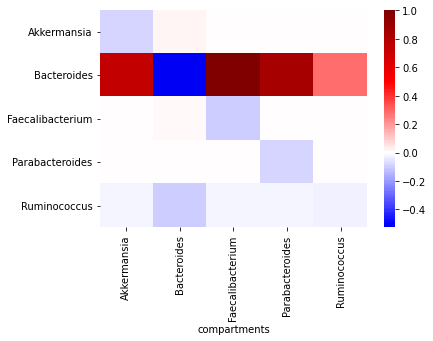

In [24]:
import seaborn as sns

ko = com.knockout_taxa(fraction=0.8, method="change")

sns.heatmap(ko, cmap="seismic", center=0)

Here the rows denote the knocked-out taxa and the columns the chnage in growth rate for all taxa. We used the the same tradeoff ("fraction") as before and asked for getting relative changes in growth rates (%change compared to baseline growth rate). We can see that there is a lot of competetion but also some strong cooperative interactions between Ruminicoccus and other genera.

## The flux capacitator

Here is how you would run the cooperative tradeoff for a single model. We can follow that up with pFBA to get all fluxes in the system.

In [27]:
sol = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
sol

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Akkermansia,0.121702,0.061570,2274,1386
Bacteroides,0.626469,0.326576,3307,1887
Faecalibacterium,0.124280,0.064240,1986,1472
Parabacteroides,0.092408,0.047597,2870,1747
Ruminococcus,0.035140,0.017461,2983,1793
medium,NaN,NaN,718,718


The returned solution contains all fluxes in `sol.fluxes`. An `NaN` entry denotes that this reaction is not present in the organism.

In [28]:
sol.fluxes.head()

reaction,12DGR180ti,12PPDSDH,12PPDt,12aHSDHe,15DAPt,1P4H2CBXLAH,23DHMPO,23PDE2,23PDE4,23PDE7,...,rtranscription,sink_PGPm1[c],sink_dmbzid,sink_gthrd(c),sink_mqn7(c),sink_mqn8(c),sink_pheme(c),sink_q8(c),sink_s,sink_sheme(c)
compartment,,,,,,,,,,,,,,,,,,,,,
Akkermansia,NaN,NaN,-0.000002,NaN,NaN,NaN,1.084970e-09,NaN,NaN,NaN,...,0.061570,NaN,NaN,-1.885492e-04,NaN,NaN,NaN,NaN,0.000269,-0.000212
Bacteroides,NaN,NaN,0.000004,NaN,NaN,-9.205050e-09,-7.412547e-07,4.654284e-09,4.654284e-09,4.654284e-09,...,0.324862,NaN,0.000144,-2.852111e-04,NaN,NaN,NaN,NaN,0.000028,NaN
Faecalibacterium,0.000483,NaN,NaN,0.000006,NaN,-4.319440e-09,2.340656e-06,7.121306e-09,7.121306e-09,7.121306e-09,...,0.061494,0.000003,NaN,-2.823001e-04,-0.000002,-0.000557,-0.000267,-0.000289,NaN,-0.000285
Parabacteroides,0.000294,NaN,-0.000015,NaN,NaN,-1.752606e-09,-1.477510e-08,-2.091964e-09,-2.091964e-09,-2.091964e-09,...,0.045086,NaN,0.000014,-9.257477e-05,NaN,NaN,NaN,NaN,0.000019,NaN
Ruminococcus,0.000023,-0.000008,0.000005,0.000002,-0.000009,-1.264400e-08,3.299112e-06,NaN,NaN,NaN,...,0.009412,0.000007,0.000012,-7.147014e-07,NaN,NaN,NaN,NaN,NaN,NaN


The acetate export reaction has the name `EX_ac(e)`. Identify the primary acetate producer in the system. Don't forget about the accuracy of 10<sup>-3</sup>.

In [29]:
sol.fluxes["EX_ac(e)"]

compartment
Akkermansia         1.261559
Bacteroides         0.219175
Faecalibacterium    0.929972
Parabacteroides     0.061149
Ruminococcus        0.005913
medium                   NaN
Name: EX_ac(e), dtype: float64

Looks like Akkermansia is the major producer. But this is expressed as flux per gDW of bacteria. But we might want to scale this by the relative abundance to get the total amount produced by each taxon.

In [30]:
sol.fluxes["EX_ac(e)"] * com.abundances

Akkermansia         0.153534
Bacteroides         0.137306
Faecalibacterium    0.115577
Parabacteroides     0.005651
Ruminococcus        0.000208
medium                   NaN
dtype: float64

Look up at least one other reaction at https://www.vmh.life/#microbes/reactions, and get it's predicted fluxes. Does the reaction take place? If yes in which organism? Can you identify the most active fluxes in the community?

In [31]:
# Glucose
sol.fluxes["EX_glc_D(e)"]

compartment
Akkermansia        -1.069815e-01
Bacteroides         8.667209e-01
Faecalibacterium   -1.015650e-05
Parabacteroides    -2.335623e-06
Ruminococcus        4.766758e-07
medium                       NaN
Name: EX_glc_D(e), dtype: float64

In [32]:
# most active
highest = sol.fluxes.abs().mean(axis=0).sort_values(ascending=False)[0:10]
highest = highest.to_frame(name="flux").reset_index()
highest

,reaction,flux
0,GALt2_2,8.344822
1,LYSt3r,6.655289
2,GALt1r,4.172441
3,ATPS4,3.399724
4,LYSt2r,3.325442
5,EX_h2o_m,1.124724
6,FLVRxe,0.781948
7,H2Ot,0.760985
8,EX_h(e),0.702986
9,NADH6,0.658691


# 🔵 Addendum


## Choosing a tradeoff value

Even if you don't have growth rates available you can still use your data to choose a decent tradeoff value. This can be done by choosing the largest tradeoff value that still allows growth for the majority of the taxa that you observed in the sample (if they are present at an appreciable abundance, they should be able to grow). This can be done with the `tradeoff` workflow in MICOM that will run cooperative tradeoff with varying tradeoff values, which can be visualized with the `plot_tradeoff` function.

In [33]:
from micom.workflows import tradeoff
import micom

tradeoff_results = tradeoff(manifest, "models", medium, threads=2)
tradeoff_results.to_csv("tradeoff.csv", index=False)

plot_tradeoff(tradeoff_results, tolerance=1e-4)

Output()

After opeing `tradeoff_[DATE].html` you will see that, for our example here, all tradeoff values work great. This is because we modeled very few taxa, which keeps the compettion down. If you would allow for fewer abundant taxa in the models, this would change drastically. For instance, here is an example from a colorectal cancer data set:

[![tradeoff example](https://micom-dev.github.io/micom/_images/tradeoff.png)](https://micom-dev.github.io/micom/_static/tradeoff.html)

You can see how not using the cooperative tradeoff would give you nonsense results where only 10% of all observed taxa grew. A tradeoff value of 0.6-0.8 would probably be a good choice for this particular data set.